In [1]:
import tensorflow as tf
import pickle
import os
import numpy as np
import scipy.misc
import cv2
import matplotlib.pyplot as plt
import random

from mpl_toolkits.mplot3d import Axes3D

C:\Users\KH_Home\Anaconda3\envs\py35\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\KH_Home\Anaconda3\envs\py35\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\KH_Home\Anaconda3\envs\py35\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\KH_Home\Anaconda3\envs\py35\lib\site-packages\tensorflow\pyth

In [2]:
import loader
import model
from general import *

In [3]:
sess = tf.Session()

In [4]:
eloader = loader.Data('evaluation')

In [5]:
def intermediate_crop_offset(imgs, binary_mask):
    # detect axis_aligned bounding box
    # find argmin(w,h) and armax(w,h) of binary_mask
    binary_mask = tf.cast(binary_mask, tf.int32)
    binary_mask = tf.equal(binary_mask, 1)
    s = binary_mask.get_shape().as_list()

    x_range = tf.expand_dims(tf.range(s[1]), 1)
    y_range = tf.expand_dims(tf.range(s[2]), 0)
    X = tf.tile(x_range, [1, s[2]])
    Y = tf.tile(y_range, [s[1], 1])

    # bounding box
    ohs = [] # offset_height
    ows = [] # offset_width
    ths = [] # target_hegith
    tws = [] # target_width

    for i in range(s[0]):
        X_masked = tf.cast(tf.boolean_mask(X, binary_mask[i, :, :]), tf.float32)
        Y_masked = tf.cast(tf.boolean_mask(Y, binary_mask[i, :, :]), tf.float32)

        x_min = tf.cast(tf.reduce_min(X_masked), tf.int32)
        x_max = tf.cast(tf.reduce_max(X_masked), tf.int32)
        y_min = tf.cast(tf.reduce_min(Y_masked), tf.int32)
        y_max = tf.cast(tf.reduce_max(Y_masked), tf.int32)
        
        ohs.append(x_min)
        ows.append(y_min)
        ths.append(x_max - x_min)
        tws.append(y_max - y_min)
        
    return ohs, ows, ths, tws

# crop test

In [6]:
imgs, masks, depths, annos = eloader.load_batch(8)
hands = (np.ones(masks.shape) < masks).astype(int)
binary_mask = hands[:,:,:,0]
ohs, ows, ths, tws = intermediate_crop_offset(imgs, binary_mask)

In [16]:
tf.stack(ths)//32

<tf.Tensor 'floordiv_2:0' shape=(8,) dtype=int32>

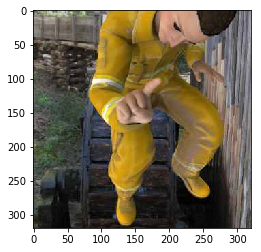

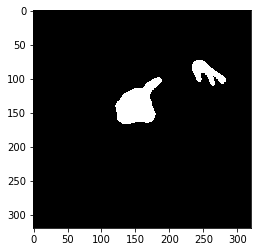

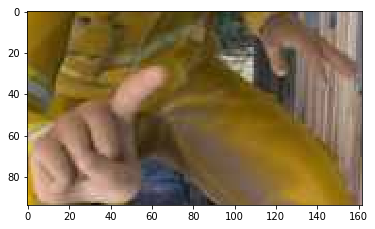

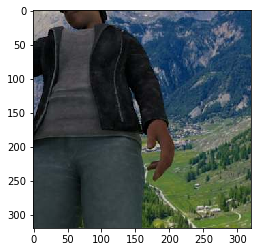

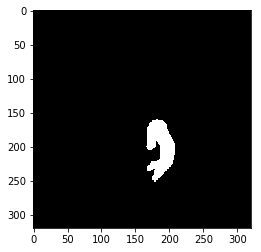

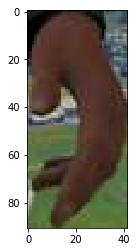

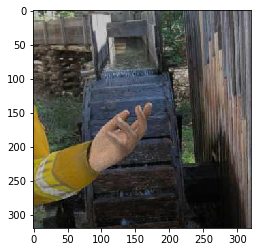

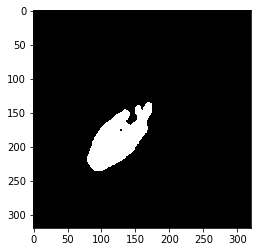

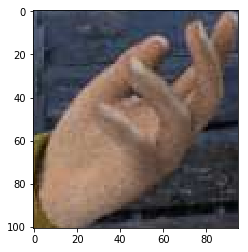

In [7]:
for idx in range(3):

    plt.imshow(imgs[idx])
    plt.show()

    plt.imshow(binary_mask[idx], 'gray')
    plt.show()
    
    imgs_crop = sess.run(tf.image.crop_to_bounding_box(imgs[idx],
                                                 ohs[idx],
                                                 ows[idx],
                                                 ths[idx],
                                                 tws[idx]))
    plt.imshow(imgs_crop)
    plt.show()
    

# Resize Test

# Test Crop and Resize

In [ ]:
imgs.shape

In [ ]:
boxes = [0,0, 100, 100]
box_indices = [0]
crop_size = [256,256]

In [ ]:
tf.image.resize_images(imgs[0], [256,256])

# Lagacy

In [ ]:
def crop_and_resize(imgs, binary_mask):
    # implement
    imgs_cr = imgs
    crop_offset = tf.ones([8, 2])
    crop_scale = tf.ones([8, 1])

    binary_mask = tf.cast(binary_mask, tf.int32)
    binary_mask = tf.equal(binary_mask, 1)
    s = binary_mask.get_shape().as_list()

    x_range = tf.expand_dims(tf.range(s[1]), 1)
    y_range = tf.expand_dims(tf.range(s[2]), 0)
    X = tf.tile(x_range, [1, s[2]])
    Y = tf.tile(y_range, [s[1], 1])

    # bounding box
    ohs = [] # offset_height
    ows = [] # offset_width
    ths = [] # target_hegith
    tws = [] # target_width
    bb_list = []
    crop_size_list = []
    offset_list = []

    for i in range(s[0]):
        X_masked = tf.cast(tf.boolean_mask(X, binary_mask[i, :, :]), tf.float32)
        Y_masked = tf.cast(tf.boolean_mask(Y, binary_mask[i, :, :]), tf.float32)

        x_min = tf.reduce_min(X_masked)
        x_max = tf.reduce_max(X_masked)
        y_min = tf.reduce_min(Y_masked)
        y_max = tf.reduce_max(Y_masked)

        start = tf.stack([x_min, y_min])
        end = tf.stack([x_max, y_max])
        bb = tf.stack([start, end], 1)
        # bb = [x_min, y_min, x_max, y_max]
        
        offset_list.append([x_min, y_min])
        bb_list.append(bb)

        crop_size_x = x_max - x_min
        crop_size_y = y_max - y_min

        crop_size_list.append([crop_size_x, crop_size_y])
        
        ohs.append(x_min)
        ows.append(y_min)
        ths.append(crop_size_x)
        tws.append(crop_size_y)
        
    return ohs, ows, ths, tws
    return bb_list, crop_size_list, offset_list
    # return imgs_cr, crop_offset, crop_scale